In [1]:
import os, cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model


2024-11-21 00:00:47.662024: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 00:00:47.672925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732122047.686370   21818 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732122047.691191   21818 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 00:00:47.708460: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
categories = ['Eczema', 'Carcinoma', 'Rosacea', 'Acne', 'Milia', 'Keratosis']
BASE_DIR = '/home/valldy/Capstone/dataset/images'

train_dir = os.path.join(BASE_DIR, 'train')
validation_dir = os.path.join(BASE_DIR, 'test')

# Prepare the training set
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    class_names=categories
)

# Prepare the validation set
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    class_names=categories
)

Found 1914 files belonging to 6 classes.


I0000 00:00:1732122050.356655   21818 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 480 files belonging to 6 classes.


In [3]:
# Create a model with data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.4),
    tf.keras.layers.RandomTranslation(0.2,0.2),
    tf.keras.layers.RandomContrast(0.4),
    tf.keras.layers.RandomZoom(0.2),
    ])

In [4]:
# Define the preprocess function for ResNet50
def preprocess(image, label):
    data_augmentation
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

# Apply the preprocessing to the datasets
train_dataset_scaled = train_dataset.map(preprocess)
validation_dataset_scaled = validation_dataset.map(preprocess)


In [5]:
# Optimize the datasets for training
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset_scaled
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )

validation_dataset_final = (validation_dataset_scaled
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

In [6]:
def create_pre_trained_model():
    
    pre_trained_model = ResNet50(
        include_top=False,
        input_shape=(224, 224, 3),  # Set input shape to match resized images
        weights="imagenet"
    )
    
    # Make all layers non-trainable
    pre_trained_model.trainable = False

    return pre_trained_model

In [7]:
# Create the pre-trained model
pre_trained_model = create_pre_trained_model()

In [8]:
pre_trained_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
# Count the total number of parameters and how many are trainable
num_total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {num_total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 23,587,712 total parameters in this model.
There are 0 trainable parameters in this model.


In [10]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy']>0.95 and logs['loss']<0.2:
            self.model.stop_training = True
            print("\nReached 99.9% accuracy so cancelling training!")

In [11]:
def output_of_last_layer(pre_trained_model):

    last_desired_layer = pre_trained_model.get_layer('conv5_block2_out')
    last_output = last_desired_layer.output
    
    print('last layer output shape: ', last_output.shape)
    
    return last_output

In [12]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 2048)


In [13]:
def create_optimal_model(pre_trained_model, last_output):

    x = tf.keras.layers.Flatten()(last_output)

    
    x = tf.keras.layers.Dense(1024, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)  
    x = tf.keras.layers.BatchNormalization()(x)  
    x = tf.keras.layers.ReLU()(x)  
    x = tf.keras.layers.Dropout(0.5)(x)  

    x = tf.keras.layers.Dense(512, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(256, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(128, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

   
    x = tf.keras.layers.Dense(6, activation='softmax')(x)


    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)

    
    model.compile( 
        optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00001),
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
  
    return model

In [14]:
# Save your model in a variable
model = create_optimal_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 122,574,854 total parameters in this model.
There are 103,455,110 trainable parameters in this model.


In [15]:
# Run this and see how many epochs it takes before the callback fires
history = model.fit(
    train_dataset_final,
    validation_data = validation_dataset_final,
    epochs = 60,
    verbose = 2,
    callbacks = [EarlyStoppingCallback()],
)

Epoch 1/60


I0000 00:00:1732122062.232450   21940 service.cc:148] XLA service 0x7f11c8002eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732122062.232558   21940 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-21 00:01:02.409854: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732122063.305246   21940 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1732122069.264807   21940 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-11-21 00:01:22.564582: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1683_0', 100 bytes spill stores, 100 bytes spill loads

2024-11-21 00:01:23.188022:

60/60 - 29s - 482ms/step - accuracy: 0.1818 - loss: 2.7238 - val_accuracy: 0.3354 - val_loss: 1.9440
Epoch 2/60
60/60 - 8s - 127ms/step - accuracy: 0.2283 - loss: 2.4969 - val_accuracy: 0.5333 - val_loss: 1.7195
Epoch 3/60
60/60 - 5s - 79ms/step - accuracy: 0.2821 - loss: 2.3003 - val_accuracy: 0.6187 - val_loss: 1.6031
Epoch 4/60
60/60 - 5s - 86ms/step - accuracy: 0.3004 - loss: 2.2207 - val_accuracy: 0.6417 - val_loss: 1.5257
Epoch 5/60
60/60 - 5s - 81ms/step - accuracy: 0.3271 - loss: 2.1322 - val_accuracy: 0.6604 - val_loss: 1.4655
Epoch 6/60
60/60 - 5s - 86ms/step - accuracy: 0.3798 - loss: 1.9441 - val_accuracy: 0.6979 - val_loss: 1.4121
Epoch 7/60
60/60 - 5s - 83ms/step - accuracy: 0.3689 - loss: 1.9560 - val_accuracy: 0.7229 - val_loss: 1.3678
Epoch 8/60
60/60 - 8s - 130ms/step - accuracy: 0.4148 - loss: 1.8356 - val_accuracy: 0.7458 - val_loss: 1.3220
Epoch 9/60
60/60 - 5s - 81ms/step - accuracy: 0.4305 - loss: 1.7976 - val_accuracy: 0.7521 - val_loss: 1.2902
Epoch 10/60
60/60

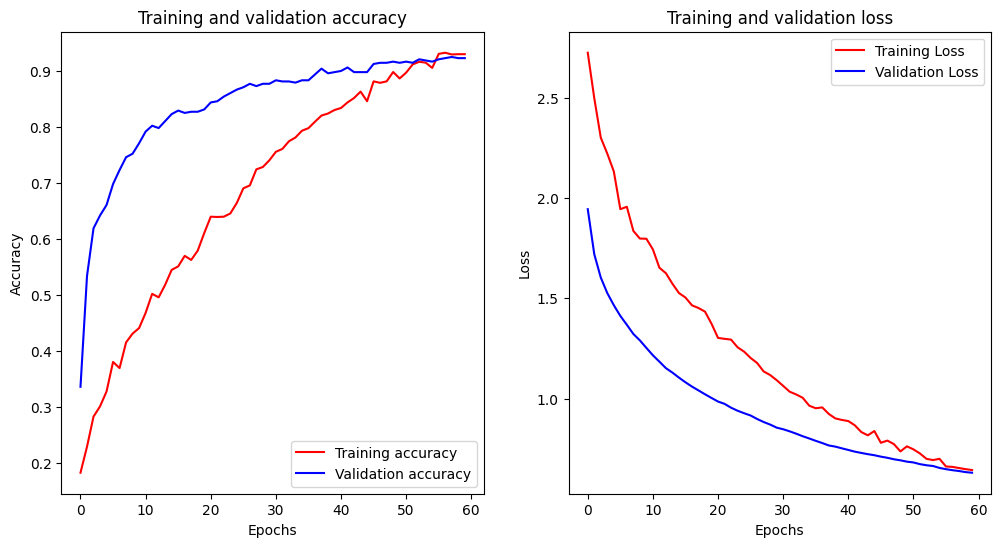

In [16]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Accuracy plot
    ax[0].plot(epochs, acc, color='red', label='Training accuracy')
    ax[0].plot(epochs, val_acc, color='blue', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Loss plot
    ax[1].plot(epochs, loss, color='red', label='Training Loss')
    ax[1].plot(epochs, val_loss, color='blue', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.show()

plot_loss_acc(history)


In [17]:
folder_path = '/home/valldy/Capstone/luar/'
image_size = (224, 224)  # Desired image size

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    
    # Check if the file is an image (optional step)
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        # Read and preprocess the image
        image = cv2.imread(file_path)
        image_resized = cv2.resize(image, image_size)
        image_expanded = np.expand_dims(image_resized, axis=0)
        
        # Print the shape of the preprocessed image
        print("Image shape:", image_expanded.shape)
        
        # Make predictions
        pred = model.predict(image_expanded)
        output_class = categories[np.argmax(pred)]
        
        # Print the predicted class
        print(f"The predicted class for {filename} is {output_class}")

Image shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
The predicted class for acne-Screenshot 2024-11-14 222704.png is Acne
Image shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The predicted class for carcinoma-Screenshot 2024-11-14 223129.png is Carcinoma
Image shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
The predicted class for acne-Screenshot 2024-11-14 222622.png is Milia
Image shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The predicted class for milia-Screenshot 2024-11-14 224238.png is Milia
Image shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The predicted class for eczema-Screenshot 2024-11-14 222858.png is Eczema
Image shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
The predicted class for carcinoma-Screenshot 2024-11-14 223152.png is Carcinoma
Image shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The predicted class for keratosis-Screenshot 2024-11-14 223802.png is Keratosis

In [18]:
saved_model_path = "./tflite/mymodel.keras"

# YOUR CODE HERE
model.save(saved_model_path)

In [19]:
#! tensorflowjs_converter \
   # --input_format=keras \
   # {saved_model_path} \
   # "./"

In [20]:
#!zip MODEL.zip *.bin model.json

In [21]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [22]:
# Initialize the TFLiteConverter with the saved model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Set the optimizations (for example, optimize for size and performance)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Invoke the converter to generate the TFLite model
tflite_model = converter.convert()


INFO:tensorflow:Assets written to: /tmp/tmpm9x1t96n/assets


INFO:tensorflow:Assets written to: /tmp/tmpm9x1t96n/assets


Saved artifact at '/tmp/tmpm9x1t96n'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  139723281155520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139720427680336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139719344691856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139719344692912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139719344690624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139719344690272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139719344451072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139719344450192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139719341817168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139719341816112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13971934181734

W0000 00:00:1732122468.951851   21818 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732122468.951904   21818 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-21 00:07:48.952301: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpm9x1t96n
2024-11-21 00:07:48.963193: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-21 00:07:48.963225: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpm9x1t96n
I0000 00:00:1732122469.081148   21818 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2024-11-21 00:07:49.100420: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-21 00:07:50.043124: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpm9x1t96n
2024-11-21 00:07:50.220574: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

In [23]:
import pathlib
tflite_model_file = pathlib.Path('./tflite/modelnew.tflite')
tflite_model_file.write_bytes(tflite_model)

122900400